In [175]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from lightgbm import LGBMClassifier
from pycaret.classification import * #3.3.0
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer #1.4.2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# 모델 수정

### 1. 데이터 분할

In [125]:
TL_file = "C:/Users/pc/Desktop/민지/교내 동아리(FARM)/동국대_산학연계 프로그램/TL_dataset_A.csv"
VL_file = "C:/Users/pc/Desktop/민지/교내 동아리(FARM)/동국대_산학연계 프로그램/VL_dataset_A.csv"

In [128]:
df = pd.read_csv(TL_file, encoding='cp949') #2876개
df.drop('Unnamed: 0', axis=1, inplace=True)

test = pd.read_csv(VL_file, encoding='cp949') #360개
test.drop('Unnamed: 0', axis=1, inplace=True)

# df 데이터 아래에 test 데이터를 합치기
df_combined = pd.concat([df, test], ignore_index=True)
print(df_combined.shape)
df_combined.head(5)

(3236, 3)


,ID,위기단계,audio_text
0,2,학대의심,"['네. 건강해요.', '무릎이 까졌어요.', '한 일주일 전이요.', '아빠랑 같..."
1,4,학대의심,"['네. 일주일 전에 머리를 많이 맞았는데 계속 아파요.', '아빠한테요.', '이..."
2,5,상담필요,"['건강해요.', '아니요.', '제가 좋아하는 물고기 영상 볼 때요.', '제가 ..."
3,6,응급,"['네. 다쳤어요.', '손바닥이랑 종아리랑 얼굴이랑 등이요.', '병원은 안 갔는..."
4,7,학대의심,"['허벅지랑 입이 아파요.', '새엄마가 거짓말한다고 때렸어요.', '허벅지는 피랑..."


In [127]:
# y값 라벨을 숫자, 이진분류로 변경
map_dict = {
    '정상군': 0,
    '관찰필요': 0,
    '상담필요': 1,
    '학대의심': 1,
    '응급': 1
}

df['위기단계2'] = df['위기단계'].map(map_dict)
y = df['위기단계2'] # 위기단계2를 Label로 사용

In [5]:
df_combined1 = df_combined.copy()

In [129]:
# y값 라벨을 숫자, 이진분류로 변경
map_dict = {
    '정상군': 0,
    '관찰필요': 0,
    '상담필요': 1,
    '학대의심': 1,
    '응급': 1
}

df_combined1['위기단계2'] = df_combined1['위기단계'].map(map_dict)
y = df_combined1['위기단계2'] # 위기단계2를 Label로 사용

In [130]:
# TF-IDF 벡터화
tfidfv = TfidfVectorizer(max_features=500)  ## 성능 최적화를 위해 피처 수(단어 개수) 제한
X = tfidfv.fit_transform(df_combined1['audio_text']).toarray()
X = pd.DataFrame(X)
X.shape

(3236, 500)

총 500개 정도의 키워드가 추출되었다는 의미 (해당 단어의 중요도) </br>
*성능은 500,1000,2000,3000이 모두 비슷하게 나오기에 500으로 진행함 (3000인 경우에 0.01% 더 높긴함)

In [131]:
#기존데이터와 벡터화된 데이터 결합
df_combined2 = pd.concat([df_combined1, X], axis=1)

In [168]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 최종적으로 얻은 데이터셋 크기 출력 (7:1.5:1.5)
print(f'훈련 데이터: {len(X_train)}개, 테스트 데이터: {len(X_test)}개')

훈련 데이터: 2588개, 테스트 데이터: 648개


### 2. 모델 선택

In [133]:
# AutoML중 하나인 pycaret 통해 모델을 선정
clf_setup = setup(data=df_combined2, 
                  target='위기단계2', 
                  session_id=42,
                  ignore_features=['ID', '위기단계', 'audio_text'] # 특정 피처 무시 가능
                  # polynomial_features=True 다항 특징으로 기존의 특징(feature)들 간의 조합으로 새로운 특징을 만드는 방법
                  ) 

,Description,Value
0,Session id,42
1,Target,위기단계2
2,Target type,Binary
3,Original data shape,"(3236, 504)"
4,Transformed data shape,"(3236, 501)"
5,Transformed train set shape,"(2265, 501)"
6,Transformed test set shape,"(971, 501)"
7,Ignore features,3
8,Numeric features,500
9,Preprocess,True


In [134]:
top3 = compare_models(sort='f1', n_select=5, fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8653,0.9381,0.8938,0.8828,0.8881,0.7190,0.7195,1.3660
catboost,CatBoost Classifier,0.8623,0.9355,0.8842,0.8857,0.8848,0.7135,0.7138,21.1800
lightgbm,Light Gradient Boosting Machine,0.8605,0.9362,0.8938,0.8758,0.8846,0.7082,0.7086,0.4940
et,Extra Trees Classifier,0.8570,0.9363,0.9107,0.8589,0.8840,0.6978,0.7002,0.1320
xgboost,Extreme Gradient Boosting,0.8578,0.9322,0.8842,0.8790,0.8814,0.7039,0.7042,0.7500
ridge,Ridge Classifier,0.8570,0.0000,0.8724,0.8873,0.8794,0.7036,0.7045,0.0580
rf,Random Forest Classifier,0.8468,0.9285,0.8901,0.8590,0.8742,0.6785,0.6793,0.1720
svm,SVM - Linear Kernel,0.8468,0.0000,0.8746,0.8712,0.8723,0.6807,0.6822,0.0580
gbc,Gradient Boosting Classifier,0.8406,0.9215,0.8761,0.8603,0.8680,0.6669,0.6672,1.5660
ada,Ada Boost Classifier,0.8305,0.9068,0.8532,0.8622,0.8576,0.6482,0.6485,0.3520


최종적으로 로지스틱 회귀가 제일 좋은 성능을 나타냄 </br>
또한, 성능평가 진행 중인 xgboost도 비교

- lr

In [186]:
# LogisticRegression 모델 생성
lr_model = top3[0]

# 모델 학습
lr_model.fit(X_train, y_train)

# 훈련, 테스트 데이터로 예측
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# 성능 평가 (훈련 데이터, 테스트 데이터)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
# report = classification_report(y_test, y_pred) #정밀도, 재현율, F1-점수를 포함한 성능 지표

print(f"Train Accuracy= {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_test_pred, zero_division=0))

Train Accuracy= 0.8895, Train F1 Score: 0.8843
Test Accuracy: 0.8719, Test F1 Score: 0.8683
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       274
           1       0.88      0.90      0.89       374

    accuracy                           0.87       648
   macro avg       0.87      0.87      0.87       648
weighted avg       0.87      0.87      0.87       648



In [152]:
# lr 하이퍼파라미터 튜닝
n_iter_search = 50

param_grid = {
    'C': [0.5, 1, 1.2, 1.4, 1.5, 1.6, 1.8], #규제강도, 기본값:1 (값이 높을수록 모델이 단순)
    'max_iter': [80, 90, 100, 120, 130, 140, 150] #기본값 100 (최대 반복 횟수)
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(lr_model, 
                                   param_grid, 
                                   n_iter=n_iter_search, 
                                   scoring='accuracy', 
                                   cv=3, 
                                   random_state=42, 
                                   verbose=2)

# 모델 훈련 (최적의 하이퍼파라미터 탐색)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] END .................................C=0.5, max_iter=80; total time=   0.0s
[CV] END .................................C=0.5, max_iter=80; total time=   0.0s
[CV] END .................................C=0.5, max_iter=80; total time=   0.0s
[CV] END .................................C=0.5, max_iter=90; total time=   0.0s
[CV] END .................................C=0.5, max_iter=90; total time=   0.0s
[CV] END .................................C=0.5, max_iter=90; total time=   0.0s
[CV] END ................................C=0.5, max_iter=100; total time=   0.0s
[CV] END ................................C=0.5, max_iter=100; total time=   0.0s
[CV] END ................................C=0.5, max_iter=100; total time=   0.0s
[CV] END ................................C=0.5, max_iter=120; total time=   0.0s
[CV] END ................................C=0.5, max_iter=120; total time=   0.0s
[CV] END ................................C=0.5,

In [205]:
# LogisticRegression 모델 생성
lr_model = LogisticRegression(C=0.8, max_iter=100)

# 모델 학습
lr_model.fit(X_train, y_train)

# 훈련, 테스트 데이터로 예측
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# 성능 평가 (훈련 데이터, 테스트 데이터)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
# report = classification_report(y_test, y_pred) #정밀도, 재현율, F1-점수를 포함한 성능 지표

print(f"Train Accuracy= {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_test_pred, zero_division=0))

Train Accuracy= 0.8883, Train F1 Score: 0.8830
Test Accuracy: 0.8750, Test F1 Score: 0.8712
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       274
           1       0.88      0.91      0.89       374

    accuracy                           0.88       648
   macro avg       0.87      0.87      0.87       648
weighted avg       0.87      0.88      0.87       648



- XGBoost

In [224]:
# XGBoost 모델 학습
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = xgb_clf.predict(X_test)

# 결과 평가
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8673, Test F1 Score: 0.8636
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       274
           1       0.88      0.89      0.89       374

    accuracy                           0.87       648
   macro avg       0.86      0.86      0.86       648
weighted avg       0.87      0.87      0.87       648



In [226]:
# 트리 개수, 트리 깊이, 학습률 변경
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=300, # 기본값 100 (트리 개수)
    max_depth=5,            # 기본값 3 (트리 깊이)
    learning_rate=0.05, # 기본값 0.1
    subsample=1.0, # 전체 데이터 사용
    colsample_bytree=1.0 # 전체 feature 사용
)

xgb_clf.fit(X_train, y_train)

# 훈련, 테스트 데이터로 예측
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# 성능 평가 (훈련 데이터, 테스트 데이터)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
# report = classification_report(y_test, y_pred) #정밀도, 재현율, F1-점수를 포함한 성능 지표

print("max_depth 튜닝 결과")
print(f"Train Accuracy= {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_test_pred))

max_depth 튜닝 결과
Train Accuracy= 0.9985, Train F1 Score: 0.9984
Test Accuracy: 0.8750, Test F1 Score: 0.8718
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       274
           1       0.89      0.90      0.89       374

    accuracy                           0.88       648
   macro avg       0.87      0.87      0.87       648
weighted avg       0.87      0.88      0.87       648



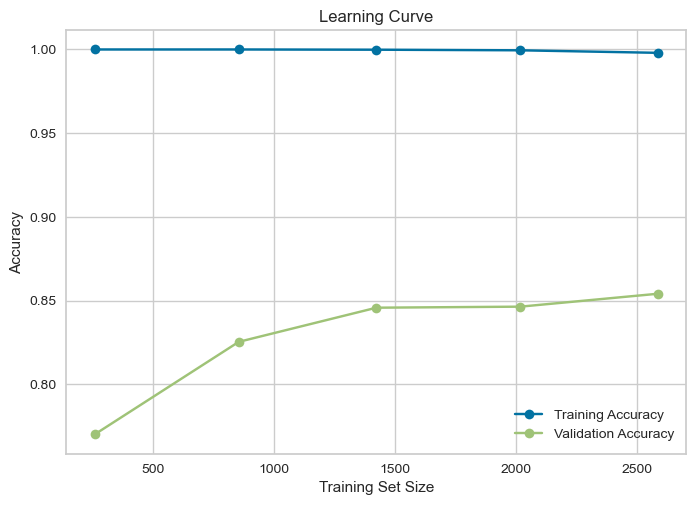

In [227]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선 생성 (X와 y는 이전에 TF-IDF로 변환한 데이터와 타겟)
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_clf, X, y, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], cv=5, scoring='accuracy')

# 학습 및 검증 정확도의 평균 계산
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# 학습 곡선 시각화
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

교차 검증을 통해 더욱 일반화된 성능을 보여줌 (약 0.86)

In [232]:
# 학습 및 검증 정확도의 평균 계산
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

valid_mean

array([0.77008987, 0.82540548, 0.84579779, 0.84641699, 0.85414639])

In [211]:
# # 기본 모델 설정
# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     n_estimators=100,       # 기본 트리 개수
#     max_depth=3,            # 기본 트리 깊이
#     learning_rate=0.1,      # 기본 학습률
#     subsample=1.0,          # 전체 데이터 사용
#     colsample_bytree=1.0    # 전체 feature 사용
# )

# # 기본 모델 학습
# xgb_clf.fit(X_train, y_train)

# # 예측 및 평가
# y_pred = xgb_clf.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# test_f1 = f1_score(y_test, y_pred, average='macro')
# print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
# print(classification_report(y_test, y_pred))


# # 트리 개수를 100에서 300으로 증가시키는 예시
# X_train_resampled, y_train_resampled은 SMOTE를 사용하여 클래스 불균형을 해결하기 위해 데이터 개수 늘린 것
# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     n_estimators=300,       # 트리 개수 증가
#     max_depth=3,
#     learning_rate=0.1,
#     subsample=1.0,
#     colsample_bytree=1.0
# )

# xgb_clf.fit(X_train_resampled, y_train_resampled)
# y_pred_resampled = xgb_clf.predict(X_test_resampled)
# print("n_estimators 튜닝 결과")
# print(classification_report(y_test_resampled, y_pred_resampled))


# # 학습률을 0.1에서 0.05로 낮추는 예시
# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     n_estimators=300,
#     max_depth=3,
#     learning_rate=0.05,      # 학습률 감소
#     subsample=1.0,
#     colsample_bytree=1.0
# )

# xgb_clf.fit(X_train_resampled, y_train_resampled)
# y_pred_resampled = xgb_clf.predict(X_test_resampled)
# print("learning_rate 튜닝 결과")
# print(classification_report(y_test_resampled, y_pred_resampled))


# # 트리 깊이를 3에서 5로 변경
# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     n_estimators=300,
#     max_depth=5,            # 트리 깊이 증가
#     learning_rate=0.05,
#     subsample=1.0,
#     colsample_bytree=1.0
# )

# xgb_clf.fit(X_train_resampled, y_train_resampled)
# y_pred_resampled = xgb_clf.predict(X_test_resampled)
# print("max_depth 튜닝 결과")
# test_accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
# test_f1 = f1_score(y_test_resampled, y_pred_resampled, average='macro')
# print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
# print(classification_report(y_test_resampled, y_pred_resampled))